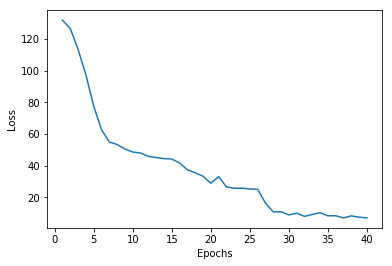

Accuracy on test set = 0.977777777778


In [17]:
import numpy as np
import random
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class MLP():
    def __init__(self, neurons_per_layer):
        self.layers = len(neurons_per_layer)
        self.neurons_per_layer = neurons_per_layer
        # weights and biases initialization
        self.biases = [np.random.normal(0, 2 / M_l, (M_l, 1)) 
                       for M_l in neurons_per_layer[1:]]
        self.weights = [np.random.normal(0, 2 / M_l, (M_l, M_l_1)) 
                        for M_l_1, M_l in zip(neurons_per_layer[:-1], neurons_per_layer[1:])]

    def forward_propagation(self, a):
        for bias, weight in zip(self.biases, self.weights):
            a = leacky_ReLU(np.dot(weight, a) + bias)
        return a

    def stochastic_gradient_descent(self, training_data, mini_batch_size, epochs, gamma, validation_data):
        n = len(training_data)
        validation_loss = []
        
        for i in range(epochs):
            random.shuffle(training_data)
            mini_batches = []
            for ind in range(0, n, mini_batch_size):
                mini_batches.append(training_data[ind:ind + mini_batch_size])
            
            for mini_batch in mini_batches:
                grad_biases = [np.zeros(bias.shape) for bias in self.biases]
                grad_weights = [np.zeros(weight.shape) for weight in self.weights]
                
                for x, y in mini_batch:
                    batch_grad_biases, batch_grad_weights = self.back_propagation(x, y)
                    grad_biases = [grad_biase + batch_grad_biase 
                                   for grad_biase, batch_grad_biase in zip(grad_biases, batch_grad_biases)]
                    grad_weights = [grad_weight + batch_grad_weight 
                                    for grad_weight, batch_grad_weight in zip(grad_weights, batch_grad_weights)]
                    
                self.biases = [bias - gamma * grad_bias 
                               for bias, grad_bias in zip(self.biases, grad_biases)]
                self.weights = [weight - gamma * grad_weight 
                                for weight, grad_weight in zip(self.weights, grad_weights)]
            
            loss = self.calc_loss(validation_data)
            validation_loss.append(loss)
        
        return validation_loss

    def back_propagation(self, x, y):
        grad_biases = [np.zeros(bias.shape) for bias in self.biases]
        grad_weights = [np.zeros(weight.shape) for weight in self.weights]

        # feedforward
        a = x
        list_a = [x]
        list_z = []
        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(weight, a) + bias
            list_z.append(z)
            a = leacky_ReLU(z)
            list_a.append(a)

        delta = self.loss_derivative(list_a[-1], y) * leacky_ReLU_derivative(list_z[-1])
        
        grad_biases[-1] = delta
        grad_weights[-1] = np.dot(delta, list_a[-2].transpose())
        
        for l in range(2, self.layers):
            z = list_z[-l]
            delta = np.dot(self.weights[-l+1].transpose(), delta) * leacky_ReLU_derivative(z)
            grad_biases[-l] = delta
            grad_weights[-l] = np.dot(delta, list_a[-l-1].transpose())
            
        return (grad_biases, grad_weights)
    
    def calc_loss(self, data):
        cost = 0.0
        t_n_y = []
        for x, y in data:
            a = self.forward_propagation(x)
            t_n_y.append(np.linalg.norm(y - a) ** 2)
        cost = 0.5 * np.sum(t_n_y)
        return cost
    
    def loss_derivative(self, a, t):
        return (a - t)
    
# Из-за dying ReLU использовал leacky_ReLU
def leacky_ReLU(z):
    return np.array([0.01 * b if (b <= 0) else b for b in z])

def leacky_ReLU_derivative(z):
    a = leacky_ReLU(z)
    return np.array([0.01 if (b <= 0) else 1 for b in a])[np.newaxis, :].transpose()
    
def one_hot_encoding(i):
    vector = np.zeros((10, 1))
    vector[i] = 1.0
    
    return vector
    
digits = load_digits()

# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_x = [x.flatten() for x in digits.images]
data_set_x = scaler.fit_transform(data_set_x)

# All data set
data_set_x = [x[np.newaxis, :].transpose() for x in data_set_x]
data_set_y = [one_hot_encoding(y) for y in digits.target]

# Split data set
x, x_test, y, y_test = train_test_split(data_set_x, data_set_y, test_size=0.2, train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, train_size=0.75)

x_train, x_test, y_train, y_test = train_test_split(data_set_x, data_set_y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

training_data = list(zip(x_train, y_train))
validation_data = list(zip(x_val, y_val))
test_data = list(zip(x_test, y_test))  

myMLP = MLP([64, 60, 60, 60, 10])
# Примерное время обучения на моем ноутбуке - 7 минут
validation_loss = myMLP.stochastic_gradient_descent(training_data, 16, 40, 0.01, validation_data)

y_result = [np.argmax(myMLP.forward_propagation(x)) for x in x_test]
y_test_scalar = [np.argmax(y) for y in y_test]

epochs = np.arange(len(validation_loss)) + 1
plt.plot(epochs, validation_loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

print("Accuracy on test set =", accuracy_score(y_test_scalar, y_result))